# GANs &ndash; Part 2: Supervised regression with an extra GAN loss

Author: Sebastian Bujwid <bujwid@kth.se>

Refer to [./README.md](./README.md) for general comments.

## Objectives
  
In this part of the practical, we will demonstrate that GAN training can be utilized not only for unsupervised generation of realistic samples but also, for example, for helping supervised training.

## Introduction

In supervised learning, specifying the loss function in some cases might actually be quite challenging. Standard loss functions, like cross-entropy or mean squared error (MSE), typically assume that the output closer to the ground-truth is better. Even though it might seem like a reasonable assumption, it might not work great in the presence of higher uncertainties. That could be, for example, when multiple answers seem possible but the model has no way of telling which one of them is true - 
then the best thing it can do (with respect to the loss function) is to average the answers that seem possible. Is the average of two possible outputs a good answer, though? Not necessarily!
Consider the figure below with some example toy regression problem which is used in this assignment:

<table><tr>
<td>
    <img alt="Toy dataset: regression with MSE" src="./imgs/step2_mse_regression.png"/>
    <div align="center">
        <strong>MSE loss:</strong><br>
        the region in the center (connecting the two regions of data) might minimize MSE but the data in that regions is very unlikely to occur.
    </div>
</td>
<td>
    <img alt="Toy dataset: regression with MSE & GAN" src="./imgs/step2_mse_and_gan_regression.png"/>
    <div align="center">
        <strong>MSE + GAN loss:</strong><br>
        the model learns to (almost) avoid the region in the center where data samples are very unlikely to occur. 
        &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
        &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
    </div>
</td>
</tr></table>

Which of the models is better?
That really depends on the problem you're trying to solve and the properties of the solution you care about.

A similar example to illustrate potential benefit of using GAN for supervised problem could be for example super-resolution:
<img src="./imgs/step2_superres_gan.png"/>
<div align="center">
Super-resolution:
(Left) Optimized for MSE; (Right) Using GAN
<br>
Source: <a href="https://openaccess.thecvf.com/content_cvpr_2017/papers/Ledig_Photo-Realistic_Single_Image_CVPR_2017_paper.pdf">SRGAN</a>
</div>

The image produced by the model using MSE loss is blurry, while the one generated by the model trained with GAN loss is much sharper.

In some sense, one could think of the discriminator as a loss function that is learned and which represents whether the model's output is similar to the real data samples.
As it would be difficult to specify such a loss function manually, the concept of GAN training (or using a discriminator) can be used for many different problems and in many different settings, even supervised training.
In this part of the practical, we will use the GAN training on the supervised regression problem on a toy dataset.

Note, however, that in the case of our specific regression example, uncertainty estimation methods could be more suitable for many purposes.

## Scope
- Train a supervised regression model with a mean squared error (MSE) loss
- Add a GAN loss to the supervised regression problem & train the model

---

In [ ]:
try:
    from omegaconf import OmegaConf
except ModuleNotFoundError:
    %pip install omegaconf
    from omegaconf import OmegaConf

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
seed = 42

# Toy dataset

In [3]:
def dataset_noisy_lines(n_samples, seed):
    
    def make_line(n_samples, seed):
        x, y = sklearn.datasets.make_regression(
            n_samples=n_samples // 2,
            n_features=1,
            n_informative=1,
            bias=0.5,
            effective_rank=None,
            tail_strength=0.,
            noise=5.0,
            shuffle=True,
            coef=False,
            random_state=seed)
        return np.concatenate([x, np.expand_dims(y / np.max(np.abs(y)), -1)], axis=-1)
    
    line1 = make_line(n_samples // 2, seed=seed + 1)
    line2 = make_line(n_samples // 2, seed=seed + 2) + np.array([3., 3])
    data = np.concatenate([line1, line2], axis=0) + 5.
    x, y = data[:, [0]], data[:, [1]]
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        x, y,
        test_size=0.3,
        random_state=seed,
        shuffle=True,
    )
    return (x_train, y_train), (x_test, y_test)

(3500, 1)
(3500, 1)


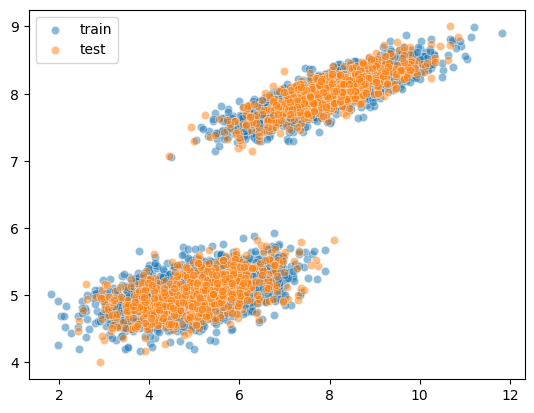

In [4]:
data_train, data_test = dataset_noisy_lines(n_samples=10000, seed=seed)
print(data_train[0].shape)
print(data_train[1].shape)
sns.scatterplot(alpha=0.5, x=data_train[0][:, 0], y=data_train[1][:, 0], label='train')
sns.scatterplot(alpha=0.5, x=data_test[0][:, 0], y=data_test[1][:, 0], label='test')
plt.show()

# Implementation

In [5]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers, stax
from jax import jit

In [6]:
from utils import plot_losses

**Mean squared error (MSE) loss**

$$
\text{MSE} = \frac{1}{n}
\sum_{i=1}^{n}
(y_i - \hat{y}_i)^2
$$

In [7]:
def mse_loss(targets, predictions):
    assert targets.ndim == predictions.ndim
    
    return jnp.mean(jnp.square(predictions - targets), axis=-1)

In [10]:
def iterable_dataset(key, data, batch_size):
    data_x, data_y = data
    assert len(data_x) == len(data_y)
    n_samples = len(data_x)
    n_batches = n_samples // batch_size
    x_shuffled, y_shuffled = jnp.split(
        jax.random.permutation(
            key, jnp.concatenate([data_x, data_y], axis=-1)
        ),
        2, axis=-1
    )
    dataset = [
        (
            x_shuffled[i * batch_size: (i + 1) * batch_size],
            y_shuffled[i * batch_size: (i + 1) * batch_size],
        ) for i in range(n_batches)
    ]
    return dataset

In [11]:
def show_predictions(model_params, model_apply, data):
    x, y = data
    pred_y = model_apply(model_params, x)
    sns.scatterplot(alpha=0.5, x=x[:, 0], y=y[:, 0], label='real_data')
    sns.scatterplot(alpha=0.5, x=x[:, 0], y=pred_y[:, 0], label='predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [12]:
regression_hparams = OmegaConf.create({
    'epochs': 2000,
    'batch_size': 512,
    'lr': 0.0001,
    'model': {
        'n_layers': 5,
        'hidden_dim': 512,
    },
})

In [13]:
def create_mlp(n_hid_layers, hid_dim, output_dim):
    layers = list(itertools.chain.from_iterable(
        [(stax.Dense(hid_dim), stax.Relu) for _ in range(n_hid_layers)]
    )) + [stax.Dense(output_dim)]
    mpl_init, mpl_apply = stax.serial(*layers)
    return mpl_init, mpl_apply

## Regression model trained with MSE

First, we will train a regression model with just the MSE loss.

In [14]:
def create_and_train_regression_model(hparams, data, test_data):
    
    x_dim, y_dim = 1, 1
    
    # Create model
    model_init, model_apply = create_mlp(
        n_hid_layers=hparams.model.n_layers,
        hid_dim=hparams.model.hidden_dim,
        output_dim=y_dim
    )

    # Initialize
    key = jax.random.PRNGKey(seed)
    key, key_model = jax.random.split(key, 2)
    
    x_shape = (-1, x_dim)
    _, model_params = model_init(key_model, x_shape)
    
    ## Initialize: optimizer
    model_opt_init, model_opt_update, model_get_params = optimizers.adam(
        step_size=hparams.lr
    )
    model_opt_state = model_opt_init(model_params)
    
    # Training functions
    def loss_fn(model_params, x, y):
        pred_y = model_apply(model_params, x)
        loss = jnp.mean(mse_loss(y, pred_y), axis=0)
        return loss
    
    @jit
    def train_step(step, model_opt_state, x, y):
        model_params = model_get_params(model_opt_state)
        
        loss, model_grads = jax.value_and_grad(loss_fn)(model_params, x, y)
        
        model_opt_state = model_opt_update(step, model_grads, model_opt_state)
        return loss, model_opt_state
    
    loss_history = []
    
    total_step = 0
    for epoch in range(hparams.epochs):
        key, key_data = jax.random.split(key)
        
        for batch_x, batch_y in iterable_dataset(key_data, data, batch_size=hparams.batch_size):
            
            loss, model_opt_state = train_step(
                step=total_step,
                model_opt_state=model_opt_state,
                x=batch_x,
                y=batch_y,
            )
            
            loss_history.append(loss)
            
            total_step += 1
            
        if epoch == 0 or (epoch < 100 and epoch % 10 == 9) or epoch % 100 == 99:
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_losses({'loss': loss_history})
            show_predictions(model_get_params(model_opt_state), model_apply, test_data)

## (Task) Train the regression model with MSE loss

The implementation is ready and you should be able just to run the training!

------------------------------ epoch 0 ------------------------------


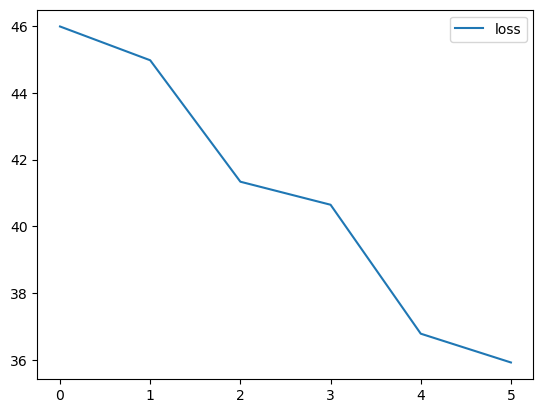

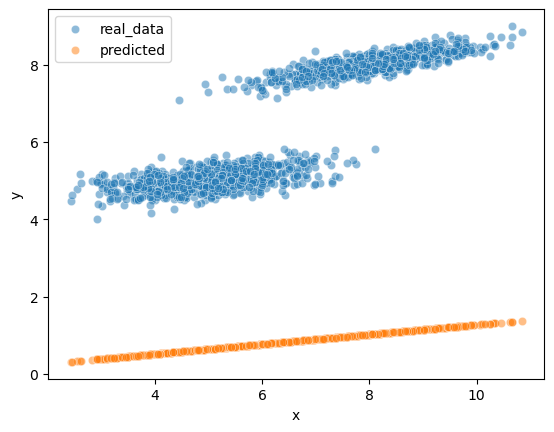

------------------------------ epoch 9 ------------------------------


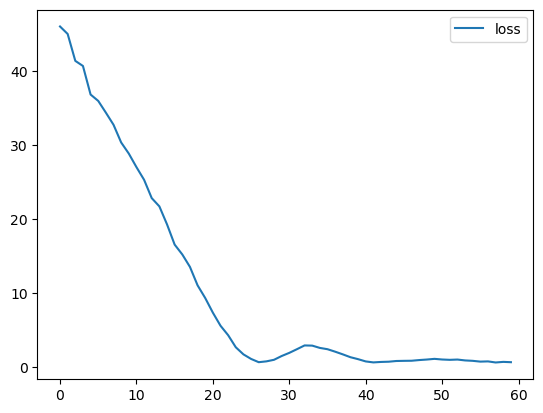

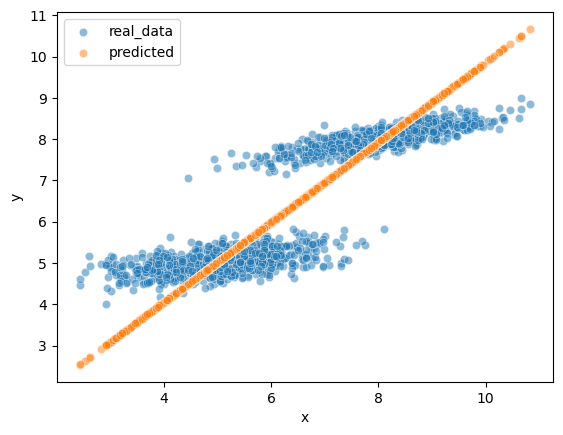

------------------------------ epoch 19 ------------------------------


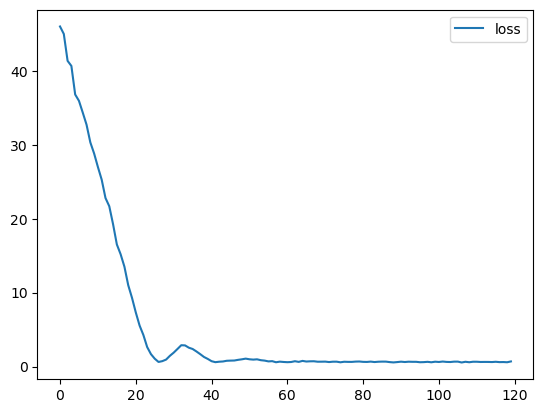

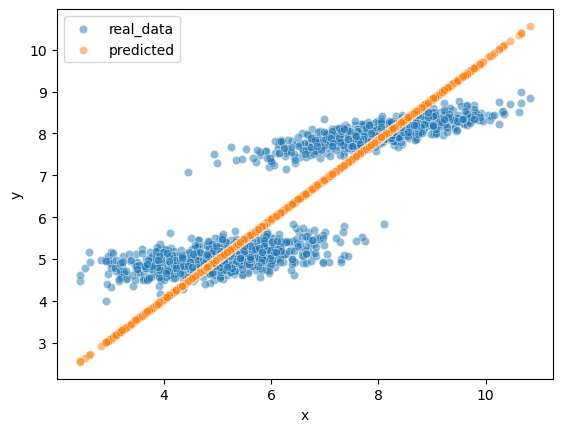

------------------------------ epoch 29 ------------------------------


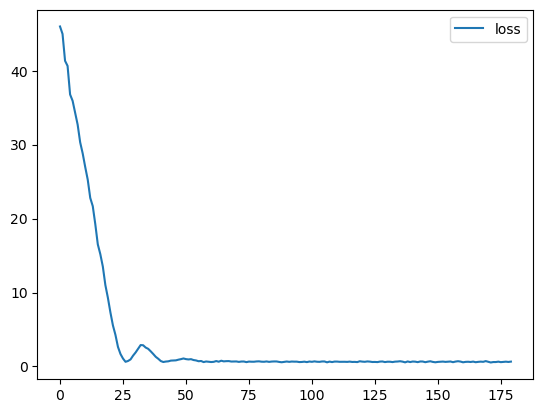

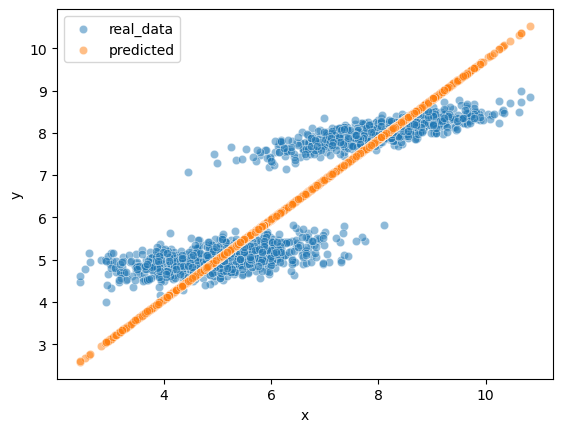

------------------------------ epoch 39 ------------------------------


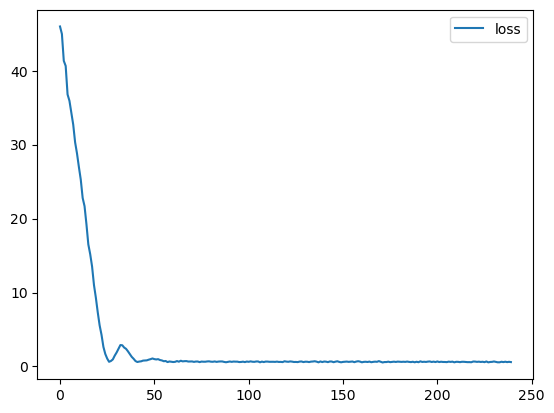

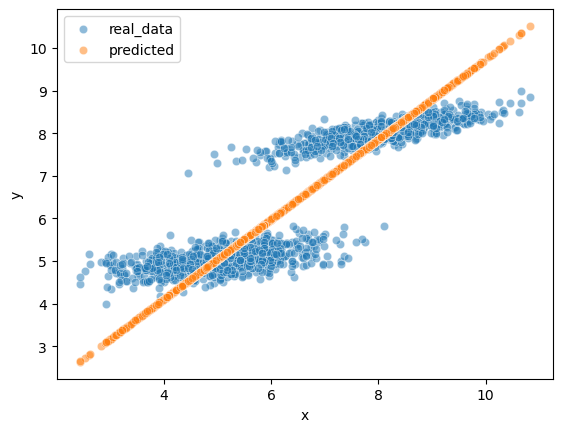

------------------------------ epoch 49 ------------------------------


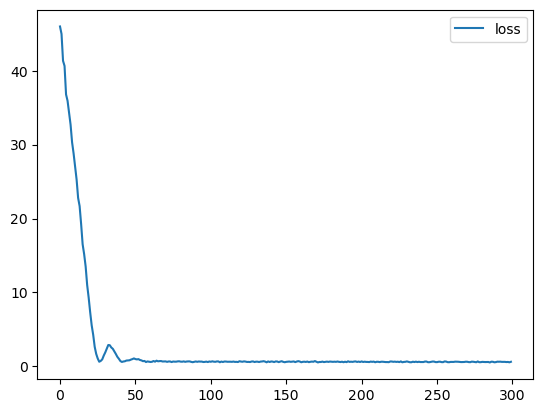

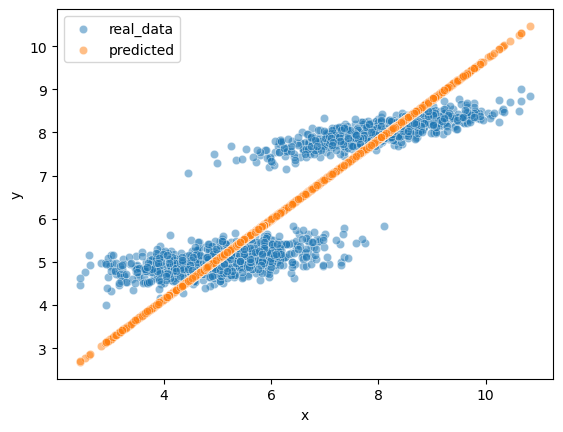

------------------------------ epoch 59 ------------------------------


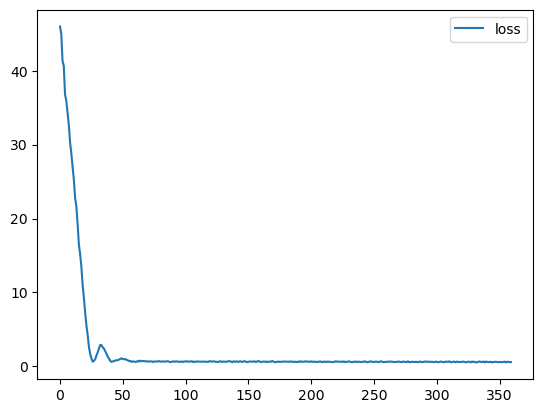

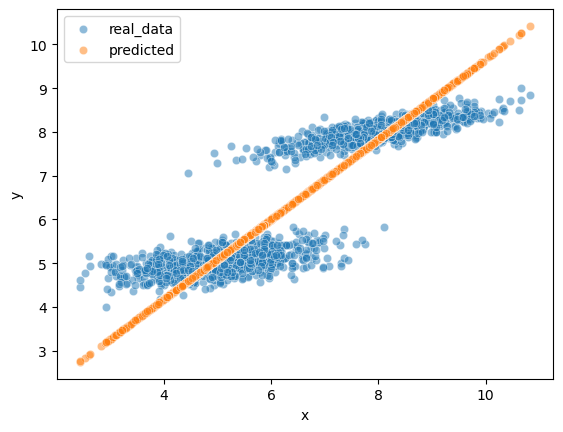

------------------------------ epoch 69 ------------------------------


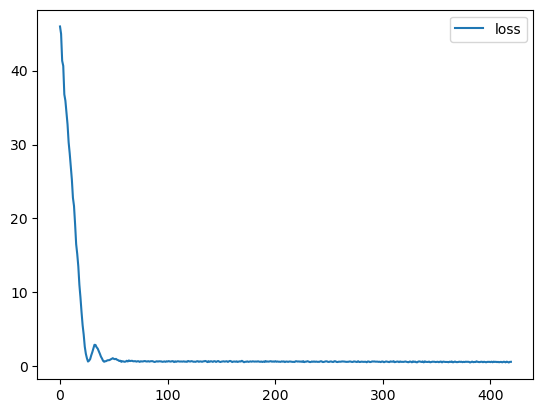

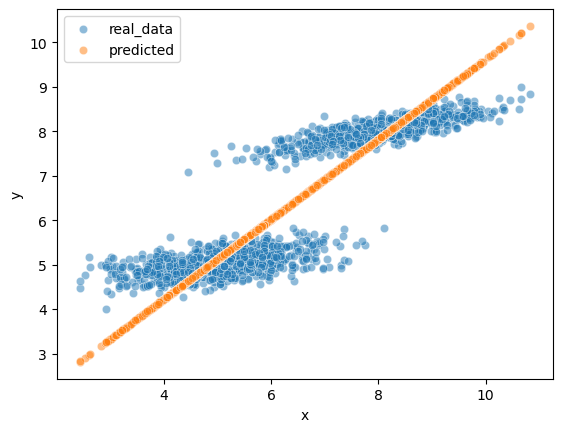

------------------------------ epoch 79 ------------------------------


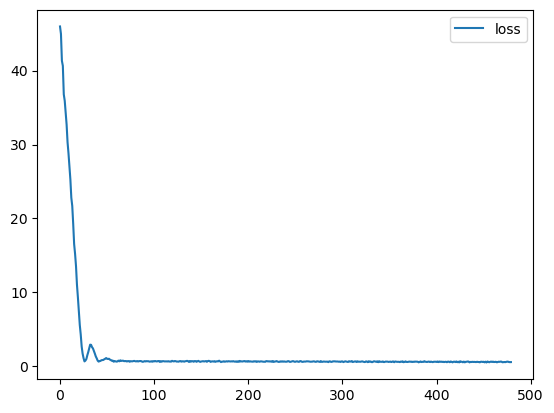

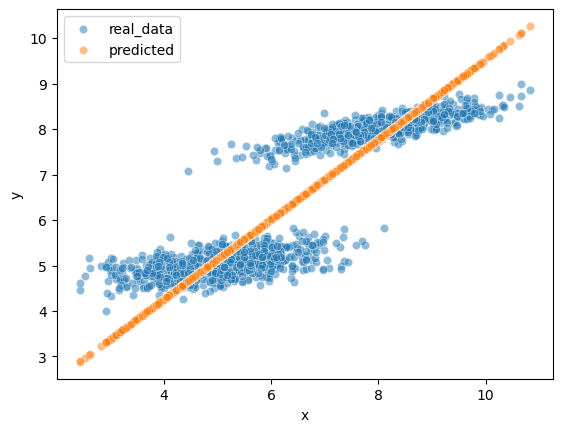

------------------------------ epoch 89 ------------------------------


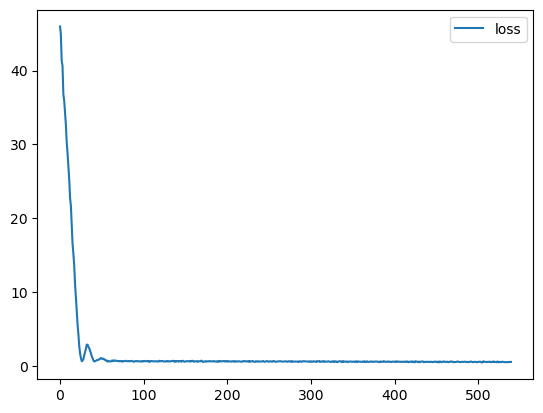

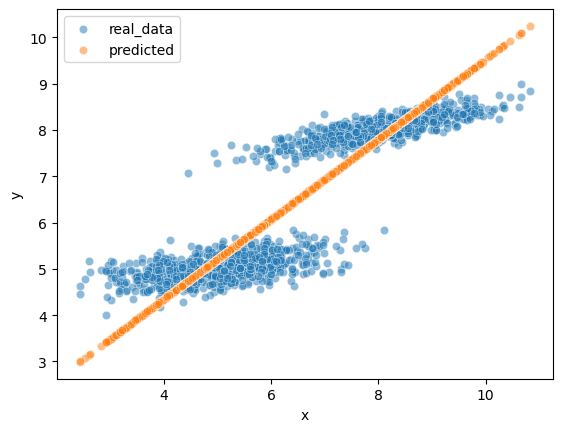

------------------------------ epoch 99 ------------------------------


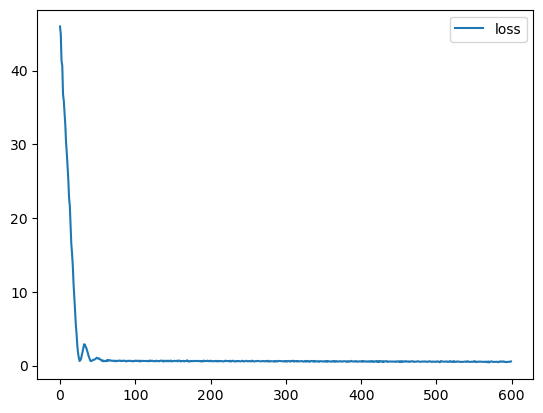

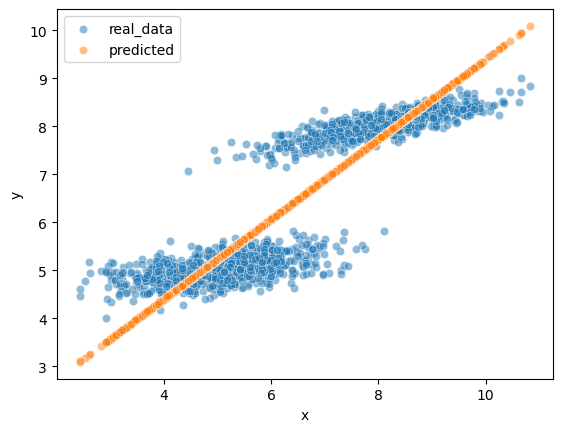

------------------------------ epoch 199 ------------------------------


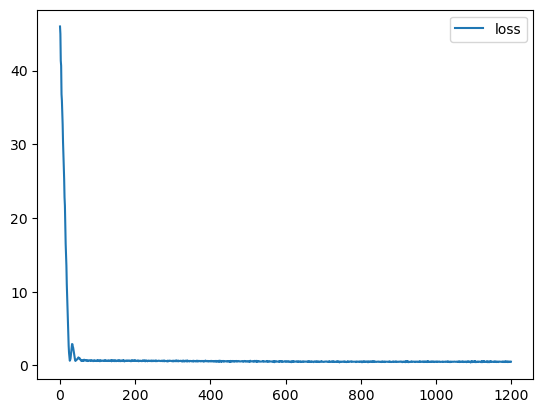

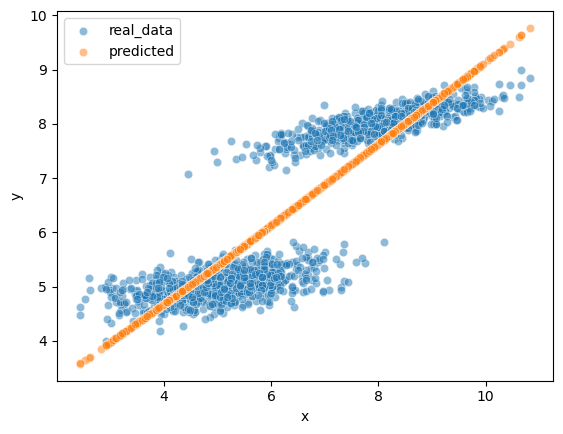

------------------------------ epoch 299 ------------------------------


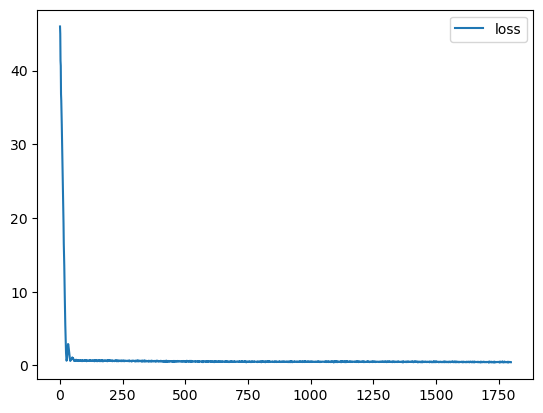

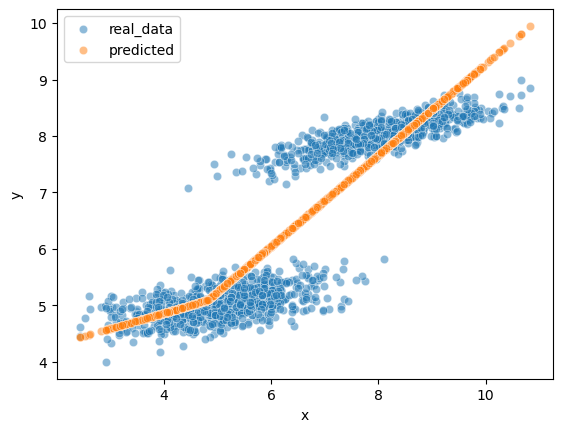

------------------------------ epoch 399 ------------------------------


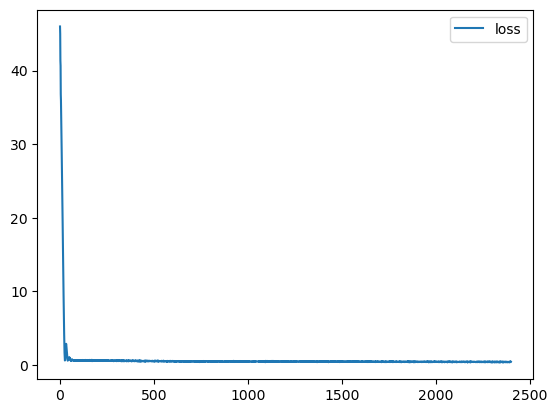

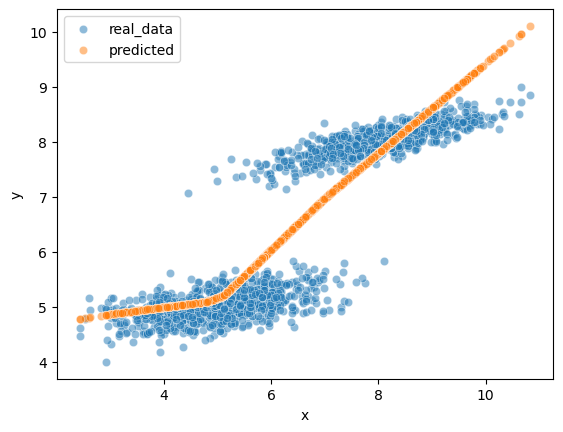

------------------------------ epoch 499 ------------------------------


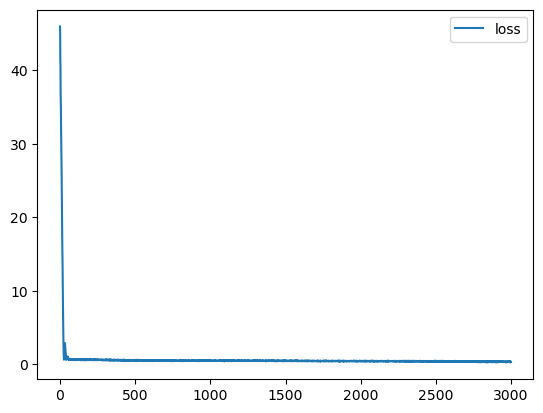

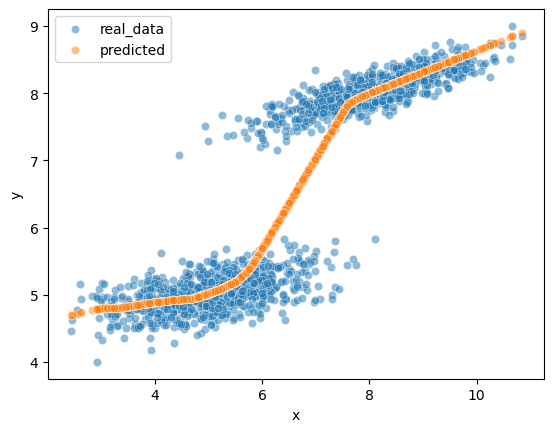

------------------------------ epoch 599 ------------------------------


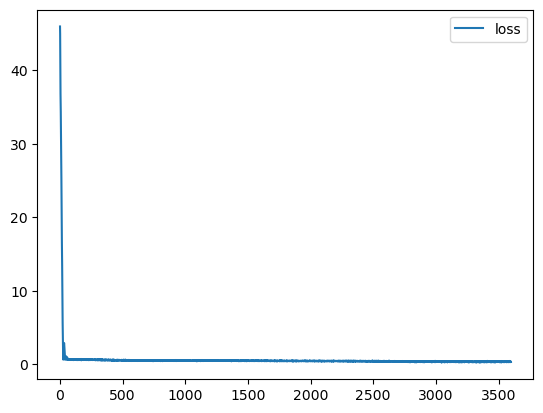

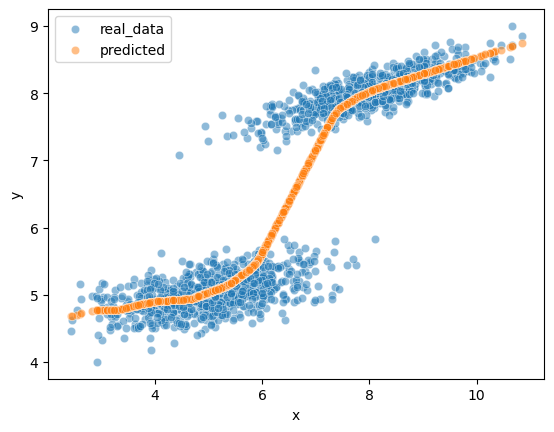

------------------------------ epoch 699 ------------------------------


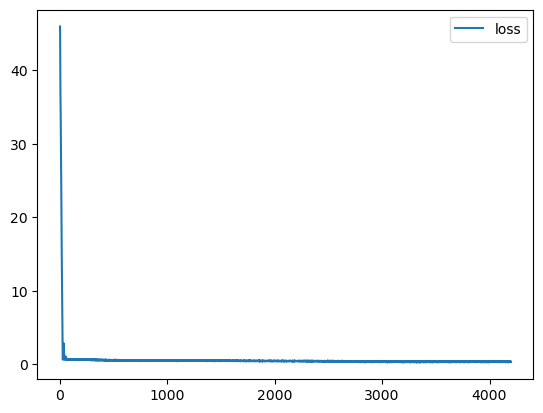

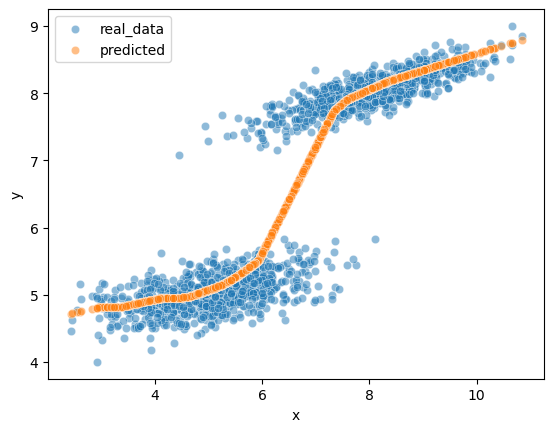

------------------------------ epoch 799 ------------------------------


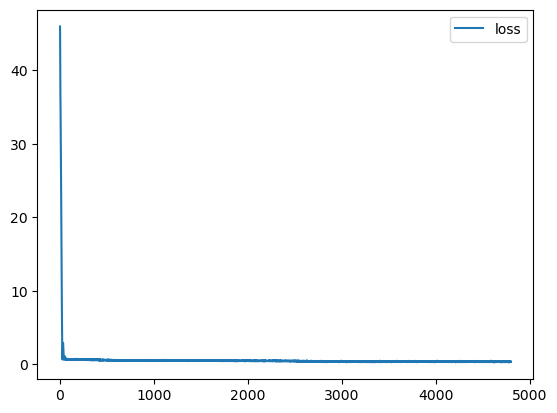

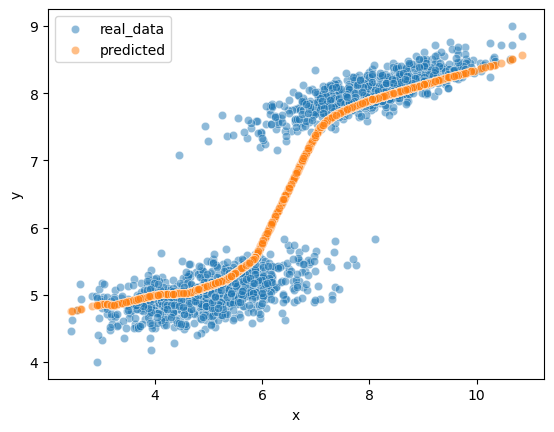

------------------------------ epoch 899 ------------------------------


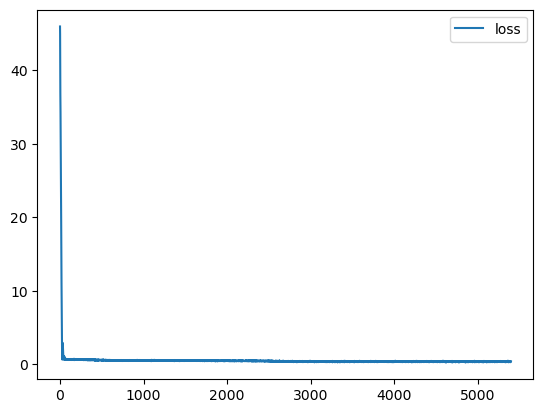

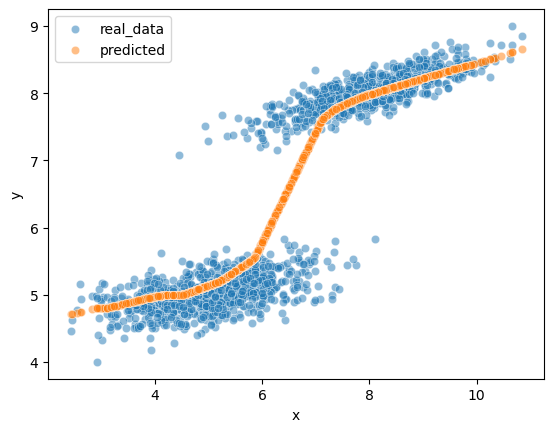

------------------------------ epoch 999 ------------------------------


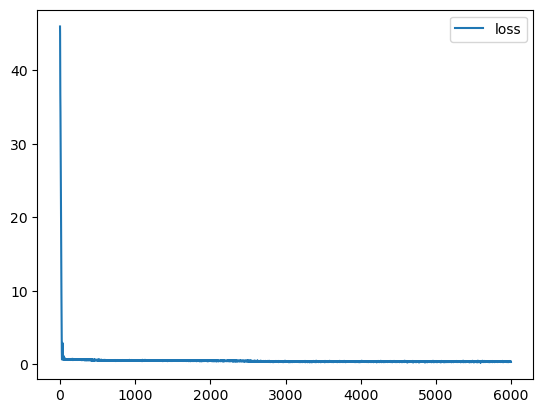

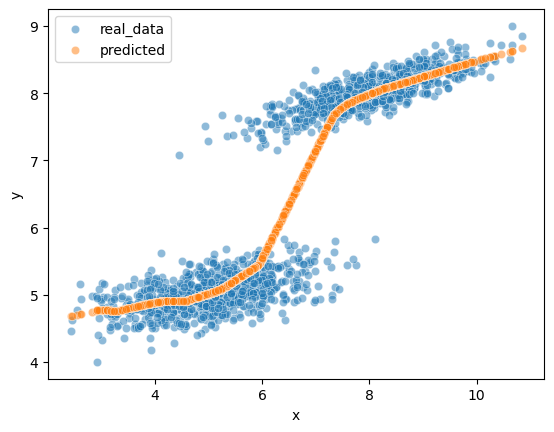

------------------------------ epoch 1099 ------------------------------


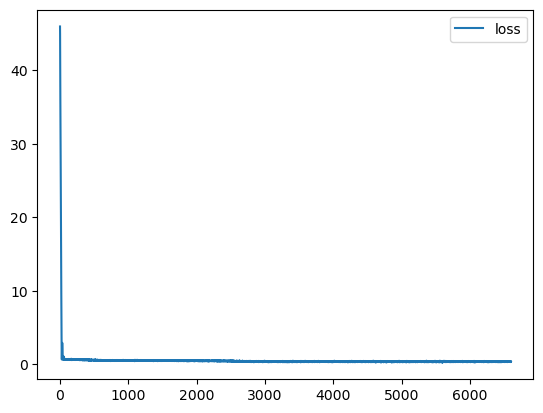

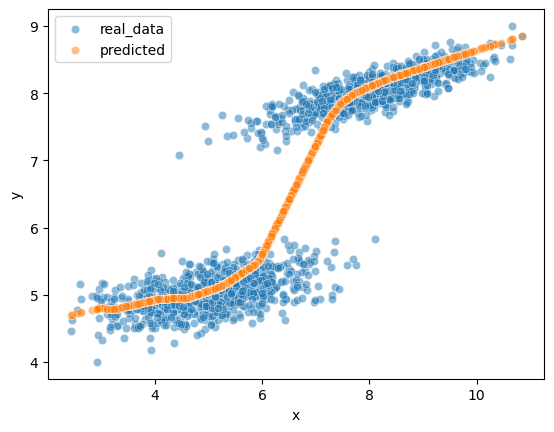

------------------------------ epoch 1199 ------------------------------


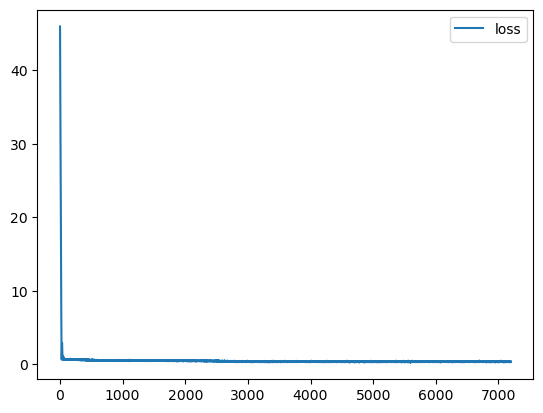

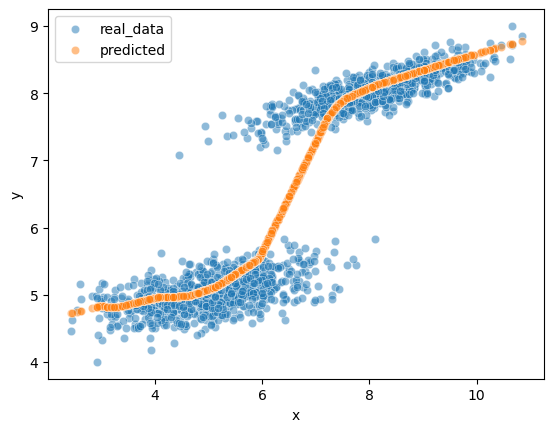

------------------------------ epoch 1299 ------------------------------


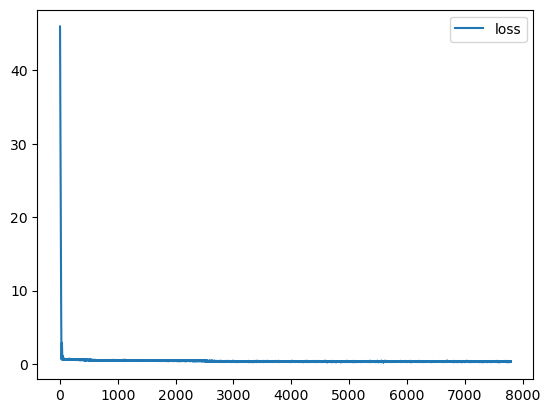

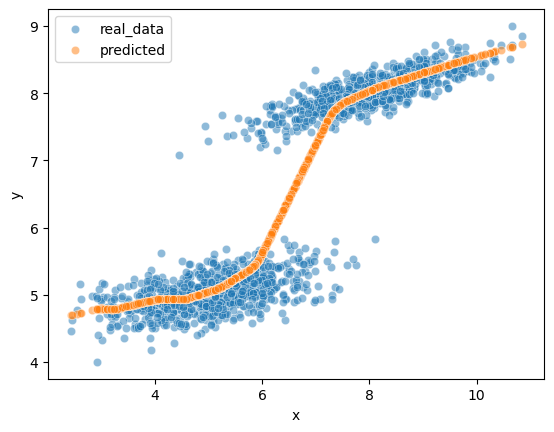

------------------------------ epoch 1399 ------------------------------


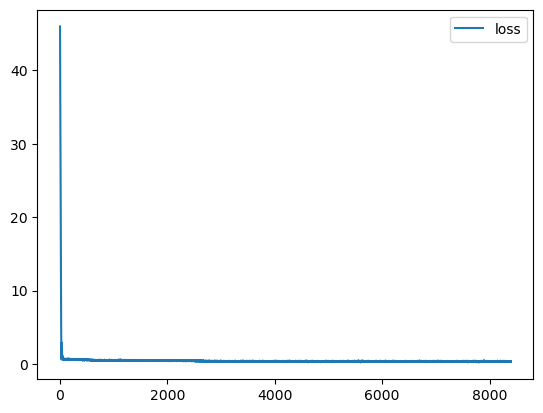

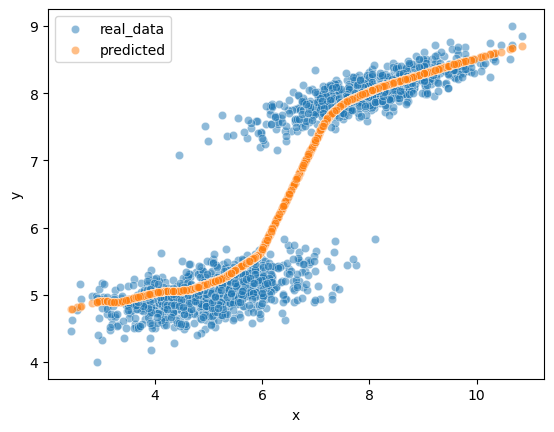

------------------------------ epoch 1499 ------------------------------


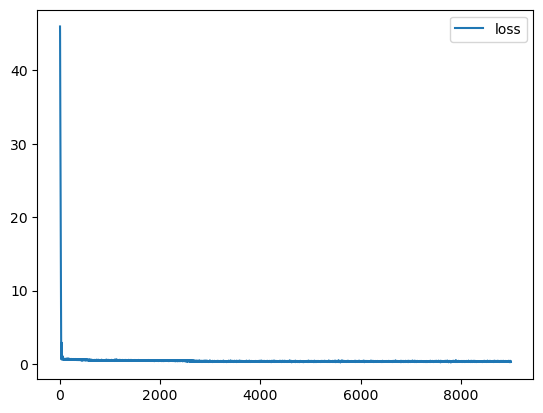

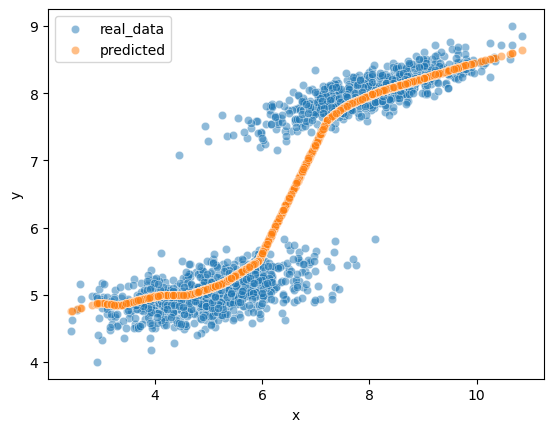

------------------------------ epoch 1599 ------------------------------


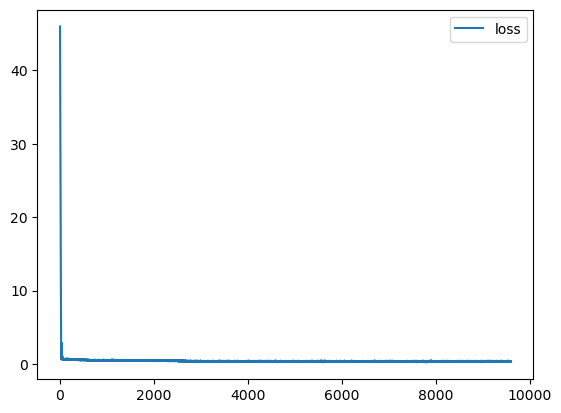

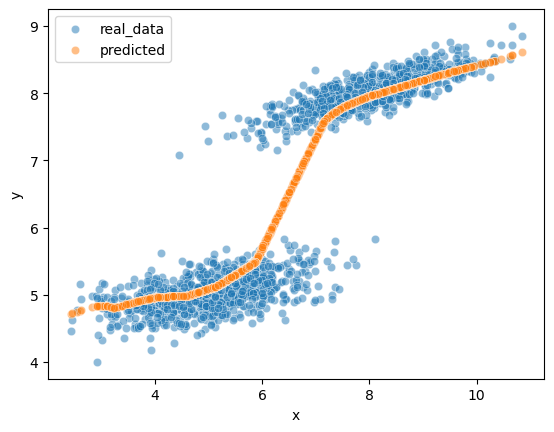

------------------------------ epoch 1699 ------------------------------


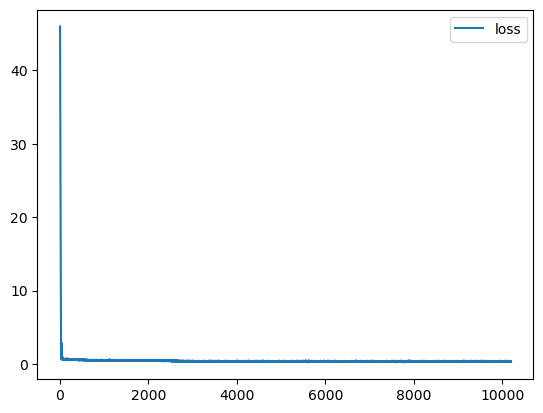

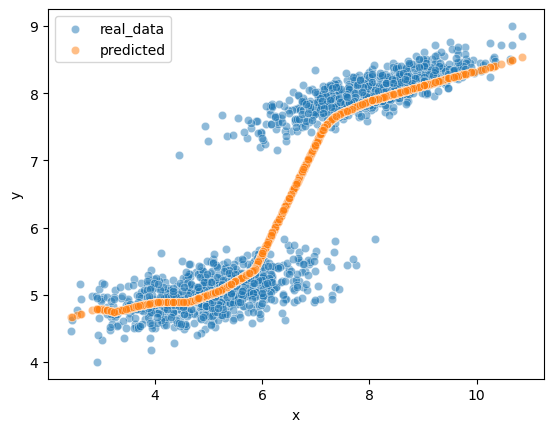

------------------------------ epoch 1799 ------------------------------


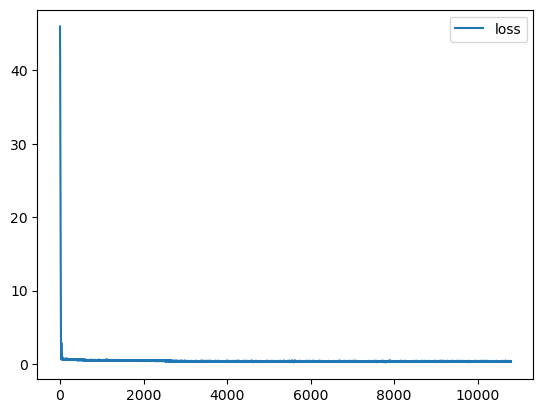

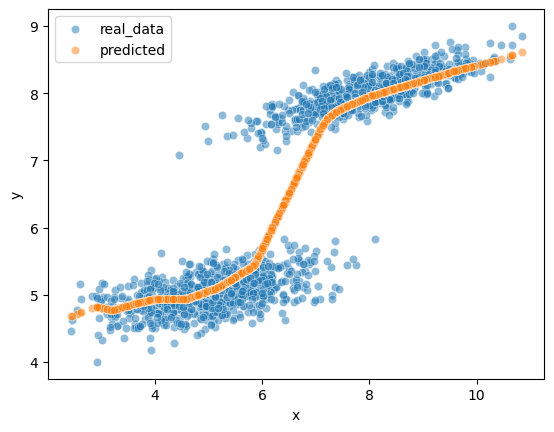

------------------------------ epoch 1899 ------------------------------


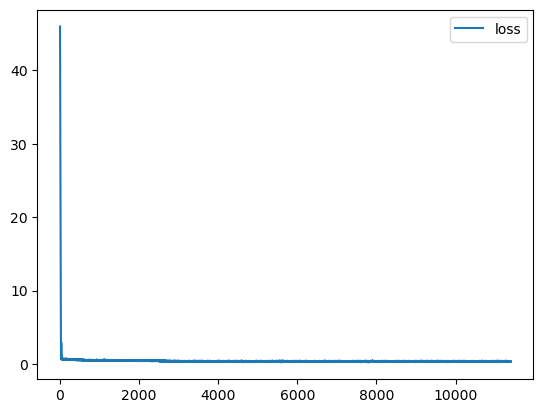

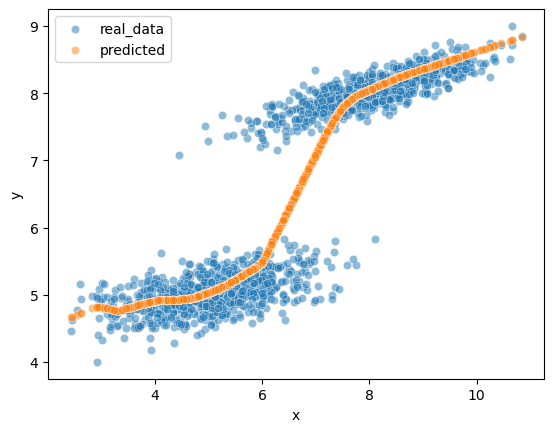

------------------------------ epoch 1999 ------------------------------


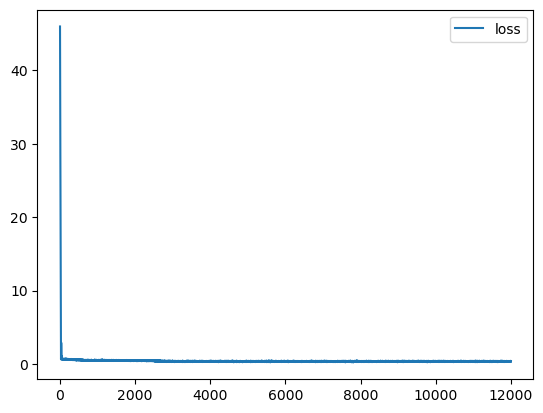

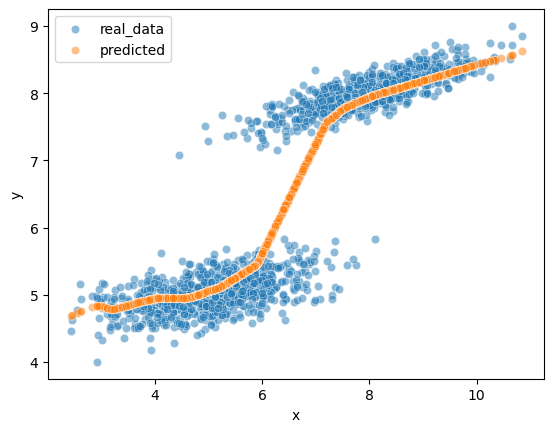

In [15]:
create_and_train_regression_model(regression_hparams, data_train, test_data=data_test)

As you hopefully able to observe, the model trained with MSE is making predictions in the center of the figure where any samples are unlikely to happen.

Now, let's see how will the predictions change if the model is trained with an additional GAN objective.

## (Task) Regression model trained with MSE + discriminator (GAN loss)

**Task:**
Implement a regression model similar to the one before but now with an extra discriminator model.
The discriminator should be trained on real vs. predicted `y` values!
In such setting, we consider the regression model as a generator, which should be trained with the MSE + GAN loss. (added, possibly with a weighting factor of `hparams.gan_loss_weight`)

Note: no input noise is needed for the generator/regressor (although it is possible to use it)

In [16]:
# You can copy/re-use the functions from Part 1
from solutions import sigmoid_cross_entropy, generator_loss, discriminator_loss

In [17]:
def create_and_train_regression_model_with_discriminator(hparams, data, test_data):
    
    x_dim, y_dim = 1, 1
    
    # Create model
    model_init, model_apply = create_mlp(
        n_hid_layers=hparams.model.n_layers,
        hid_dim=hparams.model.hidden_dim,
        output_dim=y_dim
    )
    discriminator_init, discriminator_apply = create_mlp(
        n_hid_layers=hparams.model.n_layers,
        hid_dim=hparams.model.hidden_dim,
        output_dim=1,
    )

    # Initialize
    key = jax.random.PRNGKey(seed)
    key, key_model, key_dis = jax.random.split(key, 3)
    
    x_shape = (-1, x_dim)
    y_shape = (-1, y_dim)
    _, model_params = model_init(key_model, x_shape)
    _, dis_params = discriminator_init(key_dis, y_shape)
    
    ## Initialize: optimizer
    model_opt_init, model_opt_update, model_get_params = optimizers.adam(
        step_size=hparams.lr, b1=0.5
    )
    dis_opt_init, dis_opt_update, dis_get_params = optimizers.adam(
        step_size=hparams.dis_lr, b1=hparams.dis_beta1
    )
    model_opt_state = model_opt_init(model_params)
    dis_opt_state = dis_opt_init(dis_params)
    
    
    @jit
    def train_step(step, model_opt_state, dis_opt_state, x, y):
        model_params = model_get_params(model_opt_state)
        dis_params = dis_get_params(dis_opt_state)
        
        raise NotImplementedError('Task: implement!')
        model_loss = NotImplemented
        dis_loss = NotImplemented
        model_opt_state = NotImplemented
        dis_opt_state = NotImplemented
        
        return (model_loss, dis_loss), (model_opt_state, dis_opt_state)
    
    
    loss_history = {'model': [], 'dis': []}
    
    total_step = 0
    for epoch in range(hparams.epochs):
        key, key_data = jax.random.split(key)
        
        for batch_x, batch_y in iterable_dataset(key_data, data, batch_size=hparams.batch_size):
            
            (model_loss, dis_loss), (model_opt_state, dis_opt_state) = train_step(
                step=total_step,
                model_opt_state=model_opt_state,
                dis_opt_state=dis_opt_state,
                x=batch_x,
                y=batch_y,
            )
            
            loss_history['model'].append(model_loss)
            loss_history['dis'].append(dis_loss)
            
            total_step += 1
            
        if epoch == 0 or (epoch < 100 and epoch % 10 == 9) or epoch % 100 == 99:
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_losses(loss_history)
            show_predictions(model_get_params(model_opt_state), model_apply, test_data)

## (Task) Train the regression model with MSE + GAN loss

In [ ]:
regression_with_discriminator_hparams = OmegaConf.create({
    'epochs': 2000,
    'batch_size': 512,
    'lr': 0.0001,
    'model': {
        'n_layers': 5,
        'hidden_dim': 512,
    },
    
    'gan_loss_weight': 1.,
    'dis_lr': 0.0001,
    'dis_beta1': 0.5,
    'discriminator': {
        'n_layers': 4,
        'hidden_dim': 512,
    },
})

create_and_train_regression_model_with_discriminator(
    regression_with_discriminator_hparams, data_train, test_data=data_test)

Finally, it is valuable for us to know, how long did it take you to finish this practical?